In [42]:
# Núcleo científico
import numpy as np
import networkx as nx

# Visualização
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, FancyArrowPatch
from matplotlib.lines import Line2D
from matplotlib import colormaps as cm
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

# Utilidades
from collections import Counter, defaultdict
from tqdm import tqdm
import random

# Tarefa - Detecção de Comunidades
## PCC121 - Redes Complexas
Aluno: Gabriel F. Costa

# Carregando a rede WikiMath

A **WikiMath** é uma rede temporal estática construída a partir de páginas da Wikipédia relacionadas à Matemática.

* **Nós** (vértices) (V): páginas/artigos do domínio matemático.
* **Arestas** (E): hiperligações entre páginas. Em geral, o grafo é **direcionado** (link $i \to j$); para alguns cálculos (ex.: Louvain) usa-se uma versão **não-direcionada** $G_{\mathrm{und}}$.
* **Pesos** ($w_{ij}$): opcionais (por ex., contagem/força de ligação).
* Conjunto **temporal** (snapshots) possível: $G_t=(V,E_t,W_t)$ para $t=1,\dots,T$.

> Ex. do snapshot que estamos utilizando: $|V|=1068$, $|E|=27079$, $t=(1)$.



In [45]:
!wget "https://raw.githubusercontent.com/gabrielxcosta/PCC121---Complex-Networks/main/Detec%C3%A7%C3%A3o%20de%20Comunidades/snapshot_001_WikiMath.graphml" -O snapshot_001_WikiMath.graphml

--2025-10-30 20:34:09--  https://raw.githubusercontent.com/gabrielxcosta/PCC121---Complex-Networks/main/Detec%C3%A7%C3%A3o%20de%20Comunidades/snapshot_001_WikiMath.graphml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2266764 (2.2M) [text/plain]
Saving to: ‘snapshot_001_WikiMath.graphml’

snapshot_001_WikiMa 100%[===================>]   2.16M  --.-KB/s    in 0.09s   

2025-10-30 20:34:09 (25.0 MB/s) - ‘snapshot_001_WikiMath.graphml’ saved [2266764/2266764]



# Visualizando a rede do snapshot $t=1$

✅ 1068 nós, 27079 arestas


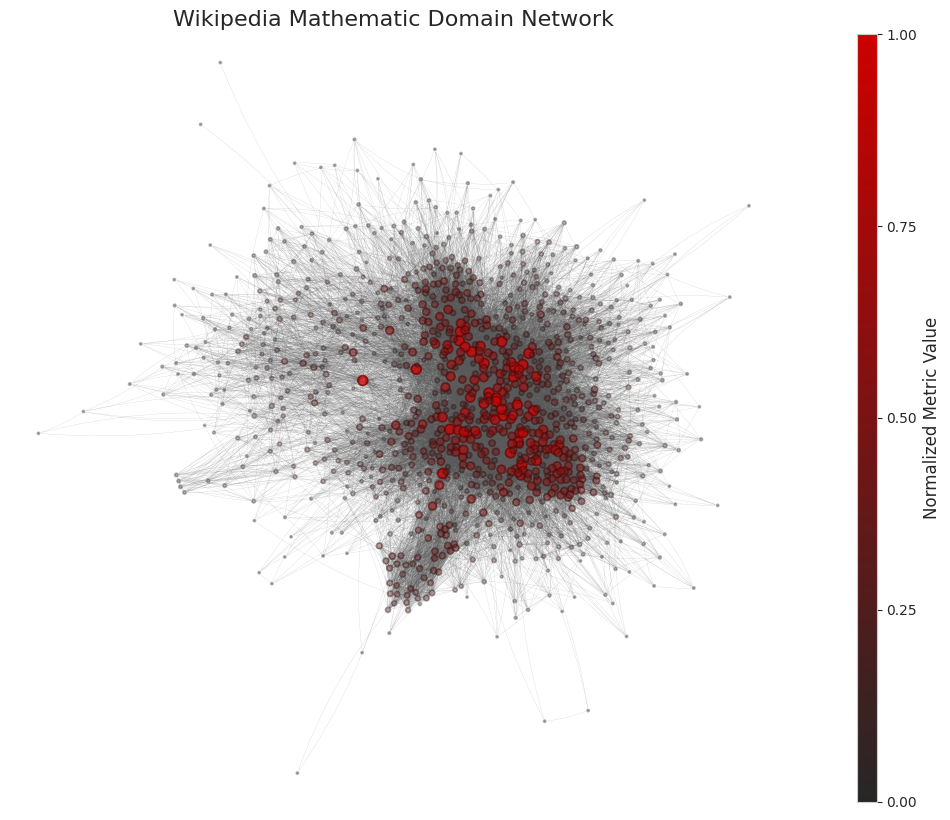

In [43]:
# -*- coding: utf-8 -*-
FIGSIZE = (10, 8)
SEED, K, ITER = 42, 0.35, 140
Q_NODE = (0.02, 0.98)            # grau -> tamanho/cor (clipping)
Q_EDGE = 0.92                    # destaca top 8% por peso
SIZE_MIN, SIZE_MAX = 5, 100      # área-base (antes do sqrt)
EDGE_BASE = (0.35, 0.35, 0.35, 0.16)
EDGE_TOP  = (0.35, 0.35, 0.35, 0.38)
EDGE_LW_MIN, EDGE_LW_MAX = 0.025, 0.25

# curva dos arcos: rad = RAD_BASE + RAD_SCALE * len_edge
RAD_BASE = 0.06
RAD_SCALE = 0.10                 # ajuste fino da curvatura

GEOPHI_GRAY = np.array([0.15, 0.15, 0.15])
GEOPHI_RED  = np.array([0.80, 0.00, 0.00])
BORDER_DARKEN = 0.55

def normalize_pos(pos):
    xs = np.array([p[0] for p in pos.values()])
    ys = np.array([p[1] for p in pos.values()])
    x0, x1 = xs.min(), xs.max(); y0, y1 = ys.min(), ys.max()
    sx = (x1 - x0) or 1.0; sy = (y1 - y0) or 1.0
    return {n: ((x - x0)/sx, (y - y0)/sy) for n, (x, y) in pos.items()}

def clip_scale(arr, q_lo, q_hi, out_min=0.0, out_max=1.0):
    a = np.array(arr, float); lo, hi = np.quantile(a, q_lo), np.quantile(a, q_hi)
    a = np.clip(a, lo, hi)
    if hi - lo < 1e-12: return np.full_like(a, (out_min + out_max)/2.0)
    return out_min + (a - lo)*(out_max - out_min)/(hi - lo)

def darken(rgb, f=BORDER_DARKEN): return tuple(max(0.0, c*f) for c in rgb)
def lerp_color(t, c0=GEOPHI_GRAY, c1=GEOPHI_RED): return tuple(np.clip((1-t)*c0 + t*c1, 0, 1))

G = nx.read_graphml("/content/snapshot_001_WikiMath.graphml")
print(f"✅ {G.number_of_nodes()} nós, {G.number_of_edges()} arestas")

pos = normalize_pos(nx.spring_layout(G, seed=SEED, k=K, iterations=ITER))

nodes = list(G.nodes())
deg = np.array([G.degree(n) for n in nodes], float)
deg01 = clip_scale(deg, *Q_NODE, 0.0, 1.0)  # ← métrica normalizada (0–1)

area = SIZE_MIN + (SIZE_MAX - SIZE_MIN)*deg01
alpha_nodes = 0.30 + 0.45*deg01
face_colors = [lerp_color(t) for t in deg01]
border_colors = [darken(fc) for fc in face_colors]

w_attr = nx.get_edge_attributes(G, "weight")
if not w_attr: w_attr = {e: 1.0 for e in G.edges()}
w = np.array([w_attr[e] for e in G.edges()], float)
w_scaled = clip_scale(w, 0.05, 0.95, EDGE_LW_MIN, EDGE_LW_MAX)
thr = np.quantile(w, Q_EDGE)
edges = list(G.edges())
edges_base = [(e, lw) for e, lw, ww in zip(edges, w_scaled, w) if ww <  thr]
edges_top  = [(e, lw) for e, lw, ww in zip(edges, w_scaled, w) if ww >= thr]

# figure com constrained_layout para acomodar a barra
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.set_title("Wikipedia Mathematic Domain Network", fontsize=16)

def draw_arc(u, v, lw, col, a):
    x1, y1 = pos[u]; x2, y2 = pos[v]
    if u == v:
        i = nodes.index(u)
        r = np.sqrt(area[i]) * 0.0022
        ax.add_patch(Arc((x1, y1 + r/3), r, r, theta1=0, theta2=320,
                         lw=lw, color=col, alpha=a, capstyle="round", zorder=1))
        return
    L = np.hypot(x2 - x1, y2 - y1)
    rad = np.clip(RAD_BASE + RAD_SCALE * L, 0.02, 0.20)
    sgn = 1 if (hash(u) ^ hash(v)) & 1 else -1
    rad *= sgn
    patch = FancyArrowPatch(
        (x1, y1), (x2, y2),
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle="-",
        mutation_scale=1.0,
        lw=lw, color=col, alpha=a,
        zorder=1, capstyle="round", joinstyle="round"
    )
    ax.add_patch(patch)

# Arestas — base e destaque (curvas)
for (u, v), lw in edges_base: draw_arc(u, v, lw, EDGE_BASE[:3], EDGE_BASE[3])
for (u, v), lw in edges_top:  draw_arc(u, v, lw*1.10, EDGE_TOP[:3],  EDGE_TOP[3])

# Nós
for i, n in enumerate(nodes):
    x, y = pos[n]
    r = np.sqrt(area[i]) * 0.0007
    ax.add_patch(plt.Circle((x, y), r,
                            facecolor=face_colors[i],
                            edgecolor=border_colors[i],
                            lw=1.2, alpha=alpha_nodes[i], zorder=2))

ax.set_xlim(-0.04, 1.04); ax.set_ylim(-0.04, 1.04)
ax.set_aspect("equal"); ax.axis("off")

# === Barra vertical (colorbar) à direita — fora do eixo principal ===
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = LinearSegmentedColormap.from_list("gephi_gray_red", [GEOPHI_GRAY, GEOPHI_RED])
norm = Normalize(vmin=0.0, vmax=1.0)

divider = make_axes_locatable(ax)
# size em porcentagem da altura do eixo; pad em polegadas → empurra bem para a direita
cax = divider.append_axes("right", size="2.5%", pad=0.8)

cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap=cmap),
    cax=cax,
    orientation="vertical"
)
cb.set_label("Normalized Metric Value", fontsize=12)
cb.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])

A figura mostra a rede WikiMath (páginas de matemática da Wikipédia ligadas por hyperlinks) desenhada com spring layout (seed=42, k=0,35, 140 iterações) normalizado para [0,1]². O tamanho dos nós é proporcional ao grau com clipping nos quantis 2–98% para evitar nós desproporcionais; a transparência cresce com a mesma métrica. As cores seguem o  ranqueamento em um gradiente cinza→vermelho conforme a métrica normalizada. As arestas são arcos suaves, com camada base cinza translúcida e destaque para o topo de pesos; larguras são escaladas por quantis (5–95%). Auto-loops aparecem como arcos pequenos sobre o próprio nó; eixos ocultos e proporção 1:1 completam o acabamento.

# Detecção de Comunidades

✅ Rede: 1068 nós, 27079 arestas
🔎 Comunidades (máx M): 7 | M = 0.4498 | método: Louvain (res*=1.00)


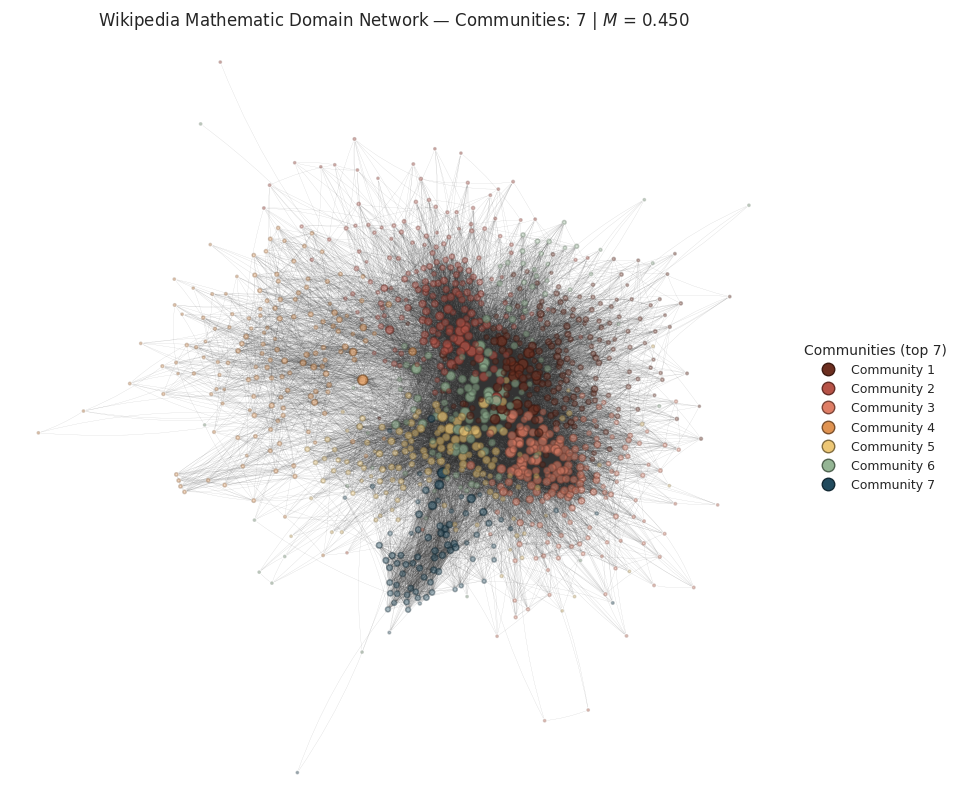

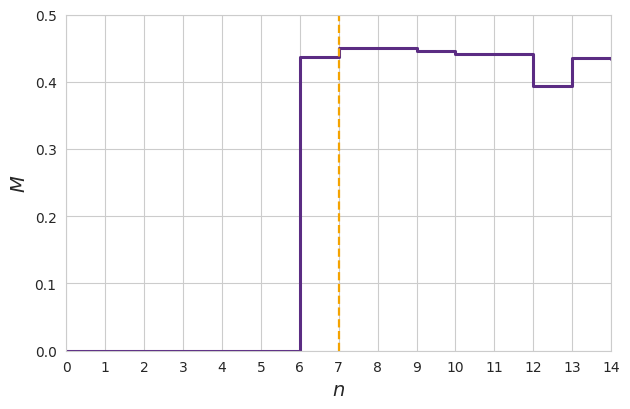

In [44]:
# -*- coding: utf-8 -*-
# Comunidades (Louvain max Q, 7 cores fixas) + Figuras:
# A) Grafo com comunidades (arestas em arcos + legenda à direita)
# B) M(Q) vs n (degraus no estilo do livro, eixo x até 15; whitegrid)
# -------------------- Parâmetros --------------------
FIGSIZE = (10, 8)
SEED, K, ITER = 42, 0.35, 140
Q_NODE = (0.02, 0.98)
Q_EDGE = 0.92
SIZE_MIN, SIZE_MAX = 5, 100
EDGE_BASE = (0.35, 0.35, 0.35, 0.14)
EDGE_TOP  = (0.20, 0.20, 0.20, 0.32)
EDGE_LW_MIN, EDGE_LW_MAX = 0.02, 0.22
RAD_BASE, RAD_SCALE = 0.06, 0.10
BORDER_DARKEN = 0.55

# 7 cores fixas (RGBA) — atribuídas às 7 MAIORES comunidades nessa ordem
HEX7 = ["#6D2F20FF", "#B75347FF", "#DF7E66FF", "#E09351FF",
        "#EDC775FF", "#94B594FF", "#224B5EFF"]
FIXED7_RGBA = [tuple(int(h[i:i+2],16)/255.0 for i in (1,3,5)) + (int(h[7:9],16)/255.0,) for h in HEX7]

# -------------------- Helpers --------------------
def normalize_pos(pos):
    xs = np.array([p[0] for p in pos.values()])
    ys = np.array([p[1] for p in pos.values()])
    x0, x1 = xs.min(), xs.max(); y0, y1 = ys.min(), ys.max()
    sx = (x1-x0) or 1.0; sy = (y1-y0) or 1.0
    return {n: ((x-x0)/sx, (y-y0)/sy) for n,(x,y) in pos.items()}

def clip_scale(arr, q_lo, q_hi, out_min=0.0, out_max=1.0):
    a = np.array(arr, float); lo, hi = np.quantile(a, q_lo), np.quantile(a, q_hi)
    a = np.clip(a, lo, hi)
    if hi-lo < 1e-12: return np.full_like(a, (out_min+out_max)/2.0)
    return out_min + (a-lo)*(out_max-out_min)/(hi-lo)

def darken(rgb, f=BORDER_DARKEN):  # só RGB
    return tuple(max(0.0, c*f) for c in rgb)

def draw_arc(ax, u, v, lw, col, a, pos, node_area, nodes):
    x1, y1 = pos[u]; x2, y2 = pos[v]
    if u == v:
        i = nodes.index(u); r = np.sqrt(node_area[i]) * 0.0022
        ax.add_patch(Arc((x1, y1 + r/3), r, r, theta1=0, theta2=320,
                         lw=lw, color=col, alpha=a, capstyle="round", zorder=1))
        return
    L = np.hypot(x2-x1, y2-y1)
    rad = np.clip(RAD_BASE + RAD_SCALE * L, 0.02, 0.20)
    sgn = 1 if (hash(u) ^ hash(v)) & 1 else -1
    rad *= sgn
    ax.add_patch(FancyArrowPatch((x1,y1), (x2,y2),
                                 connectionstyle=f"arc3,rad={rad}",
                                 arrowstyle="-", mutation_scale=1.0,
                                 lw=lw, color=col, alpha=a,
                                 zorder=1, capstyle="round", joinstyle="round"))

# -------------------- 1) Carrega rede --------------------
G = nx.read_graphml("/content/snapshot_001_WikiMath.graphml")
print(f"✅ Rede: {G.number_of_nodes()} nós, {G.number_of_edges()} arestas")
G_und = G.to_undirected() if G.is_directed() else G

# -------------------- 2) Louvain (import robusto) --------------------
community_louvain = None
try:
    from community import community_louvain as _cl
    community_louvain = _cl
except Exception:
    try:
        import community as _cl
        if hasattr(_cl, "best_partition") and hasattr(_cl, "modularity"):
            community_louvain = _cl
    except Exception:
        community_louvain = None

# -------------------- 3) Varre resolução para formar a “escada” --------------------
modularities, n_communities, partitions, resolutions = [], [], [], []
best = {"Q": -1.0, "part": None, "res": None, "k": None}

if community_louvain is not None:
    for res in np.linspace(0.5, 2.0, 25):
        part = community_louvain.best_partition(G_und, random_state=SEED, resolution=res)
        Q = community_louvain.modularity(part, G_und)
        k = len(set(part.values()))
        partitions.append(part); modularities.append(Q); n_communities.append(k); resolutions.append(res)
        if Q > best["Q"]:
            best = {"Q": Q, "part": part, "res": res, "k": k}
    method = f"Louvain (res*={best['res']:.2f})"
else:
    from networkx.algorithms.community import greedy_modularity_communities
    from networkx.algorithms.community.quality import modularity as nx_modularity
    comms = list(greedy_modularity_communities(G_und))
    part = {n: cid for cid, S in enumerate(comms) for n in S}
    Q = nx_modularity(G_und, comms)
    partitions, modularities, n_communities, resolutions = [part], [Q], [len(comms)], [np.nan]
    best = {"Q": Q, "part": part, "res": np.nan, "k": len(comms)}
    method = "Greedy modularity (NetworkX) — instale 'python-louvain' p/ varrer resolução"

print(f"🔎 Comunidades (máx M): {best['k']} | M = {best['Q']:.4f} | método: {method}")

partition = best["part"]; n_comms = best["k"]; modularity = best["Q"]

# -------------------- 4) Layout e tamanhos (∝ grau) --------------------
pos = normalize_pos(nx.spring_layout(G, seed=SEED, k=K, iterations=ITER))
nodes = list(G.nodes())
deg = np.array([G.degree(n) for n in nodes], float)
deg01 = clip_scale(deg, *Q_NODE, 0.0, 1.0)
area = SIZE_MIN + (SIZE_MAX - SIZE_MIN)*deg01
alpha_nodes = 0.30 + 0.45*deg01

# -------------------- 5) Cores — 7 maiores comunidades recebem as 7 cores fixas --------------------
cid_by_node = np.array([partition[n] for n in nodes], dtype=int)
sizes = Counter(cid_by_node)
top_cids = [cid for cid, _ in sizes.most_common(7)]

color_map = {}
for i, cid in enumerate(top_cids):
    color_map[cid] = FIXED7_RGBA[i]

fallback = cm["tab10"]
j = 0
for cid in sizes:
    if cid not in color_map:
        c = fallback(j % fallback.N)
        color_map[cid] = (0.7*c[0]+0.3, 0.7*c[1]+0.3, 0.7*c[2]+0.3, 0.9)
        j += 1

node_face = [color_map[cid] for cid in cid_by_node]
node_border = [darken(col[:3]) for col in node_face]

# -------------------- 6) Arestas (peso -> largura) --------------------
w_attr = nx.get_edge_attributes(G, "weight")
if not w_attr:
    w_attr = {e: 1.0 for e in G.edges()}
w = np.array([w_attr[e] for e in G.edges()], float)
w_scaled = clip_scale(w, 0.05, 0.95, EDGE_LW_MIN, EDGE_LW_MAX)
thr = np.quantile(w, Q_EDGE)
edges = list(G.edges())
edges_base = [(e, lw) for e, lw, ww in zip(edges, w_scaled, w) if ww <  thr]
edges_top  = [(e, lw) for e, lw, ww in zip(edges, w_scaled, w) if ww >= thr]

# -------------------- 7) FIGURA A — Grafo com comunidades + legenda à direita --------------------
figA, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.set_title(fr"Wikipedia Mathematic Domain Network — Communities: {n_comms} | $M$ = {modularity:.3f}",
             fontsize=12)

for (u, v), lw in edges_base:
    draw_arc(ax, u, v, lw, EDGE_BASE[:3], EDGE_BASE[3], pos, area, nodes)
for (u, v), lw in edges_top:
    draw_arc(ax, u, v, lw*1.10, EDGE_TOP[:3],  EDGE_TOP[3], pos, area, nodes)

for i, n in enumerate(nodes):
    x, y = pos[n]; r = np.sqrt(area[i]) * 0.0007
    ax.add_patch(plt.Circle((x, y), r,
                            facecolor=node_face[i],
                            edgecolor=node_border[i],
                            lw=1.1, alpha=alpha_nodes[i], zorder=2))

ax.set_xlim(-0.04, 1.04); ax.set_ylim(-0.04, 1.04)
ax.set_aspect("equal"); ax.axis("off")

handles, labels = [], []
for i, cid in enumerate(top_cids):
    rgba = FIXED7_RGBA[i]
    handles.append(Line2D([0],[0], marker='o', color='none',
                          markerfacecolor=rgba, markeredgecolor=darken(rgba[:3]),
                          markersize=9, lw=0))
    labels.append(f"Community {i+1}")
ax.legend(handles, labels, title="Communities (top 7)",
          loc="center left", bbox_to_anchor=(1.02, 0.5),
          frameon=False, fontsize=9, title_fontsize=10)

plt.show()

# -------------------- 8) FIGURA B — M(Q) vs n (whitegrid, x até 15) --------------------
# Agrega o melhor M por #comunidades
best_by_n = defaultdict(lambda: -np.inf)
for n, q in zip(n_communities, modularities):
    best_by_n[n] = max(best_by_n[n], q)

# ponto inicial (0, 0) para começar a “escada”
best_by_n[0] = 0.0

ns_all = np.array(sorted(best_by_n.keys()))
mask = ns_all <= 15
ns = ns_all[mask]
qs = np.array([best_by_n[x] for x in ns])

# >>> whitegrid SOMENTE para esta figura <<<
with sns.axes_style("whitegrid"):
    figB, axB = plt.subplots(figsize=(6.4, 4.2))
    axB.step(ns, qs, where="post", color="#5B2C83", lw=2.2)        # roxo em degraus
    axB.axvline(int(n_comms), ls="--", lw=1.6, color="#F4A300")    # laranja pontilhado

    axB.set_xlim(0, 14)
    axB.set_ylim(0, 0.5)
    axB.set_xlabel(r"$n$", fontsize=14)
    axB.set_ylabel(r"$M$", fontsize=14)
    axB.set_xticks(range(0, 15, 1))
    axB.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    # mantém a grade do whitegrid (não desligar)
    # axB.grid(True)  # opcional; já vem habilitado pelo estilo

    plt.tight_layout()
    plt.show()